# ***Importing Libraries***

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
import tensorflow as tf
from tensorflow import keras

# ***Gold Dataset Loading***

In [125]:
path = kagglehub.dataset_download("sid321axn/gold-price-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gold-price-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/gold-price-prediction-dataset


In [126]:
files = os.listdir(path)
print("Files found:", files)

csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    target_file = csv_files[0]
    print(f"Loading: {target_file}")
    gold_dataset = pd.read_csv(os.path.join(path, target_file))
else:
    raise FileNotFoundError(f"No CSV file found in {path}")

Files found: ['FINAL_USO.csv']
Loading: FINAL_USO.csv


In [127]:
gold_dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
1713,2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,...,20.650000,21.090000,21.090000,60507000,9.49,9.52,9.28,9.29,9.29,21598200
1714,2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,...,20.530001,20.620001,20.620001,76365200,9.25,9.92,9.23,9.90,9.90,40978800
1715,2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,...,20.700001,20.969999,20.969999,52393000,9.59,9.65,9.37,9.62,9.62,36578700
1716,2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,...,20.570000,20.600000,20.600000,49835000,9.54,9.65,9.38,9.53,9.53,22803400
1717,2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400,249.559998,250.190002,247.470001,...,20.559999,21.090000,21.090000,53866600,9.63,9.71,9.44,9.66,9.66,28417400


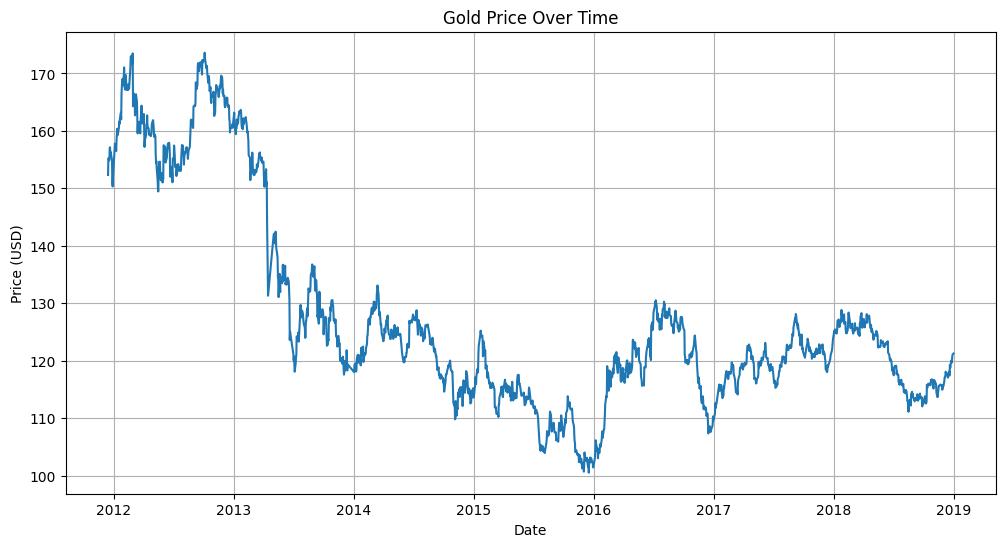

In [128]:
gold_dataset['Date'] = pd.to_datetime(gold_dataset['Date'])

gold_value = gold_dataset.sort_values(by='Date')

plt.figure(figsize=(12, 6))
plt.plot(gold_value['Date'], gold_value['Close'])
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

In [129]:
gold_indexed = gold_value.set_index('Date')

end_date = gold_indexed.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
train_start_date = test_start_date - pd.DateOffset(years=3)

print(f"Dataset ends on: {end_date.date()}")
print(f"Train range: {train_start_date.date()} to {test_start_date.date()}")
print(f"Test range: {test_start_date.date()} to {end_date.date()}")


gold_price_array_train = gold_indexed["Close"].loc[train_start_date:test_start_date].to_numpy()
gold_price_array_test = gold_indexed["Close"].loc[test_start_date:end_date].to_numpy()

print(f"Train samples: {len(gold_price_array_train)}")
print(f"Test samples: {len(gold_price_array_test)}")

Dataset ends on: 2018-12-31
Train range: 2014-12-31 to 2017-12-31
Test range: 2017-12-31 to 2018-12-31
Train samples: 747
Test samples: 248


# ***Nasdaq Dataset Loading***

In [130]:
os.environ['KAGGLE_USERNAME'] = "efedik"
os.environ['KAGGLE_KEY'] = "834060a51828f711546587422a97019f"

file_path = "NASDAQCOM.csv"
nasdaq_dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "efedik/nasdaq",
  file_path
)

print(nasdaq_dataset.head())

/tmp/ipython-input-350549443.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  nasdaq_dataset = kagglehub.load_dataset(


  observation_date  NASDAQCOM
0       2021-01-04   12698.45
1       2021-01-05   12818.96
2       2021-01-06   12740.79
3       2021-01-07   13067.48
4       2021-01-08   13201.98


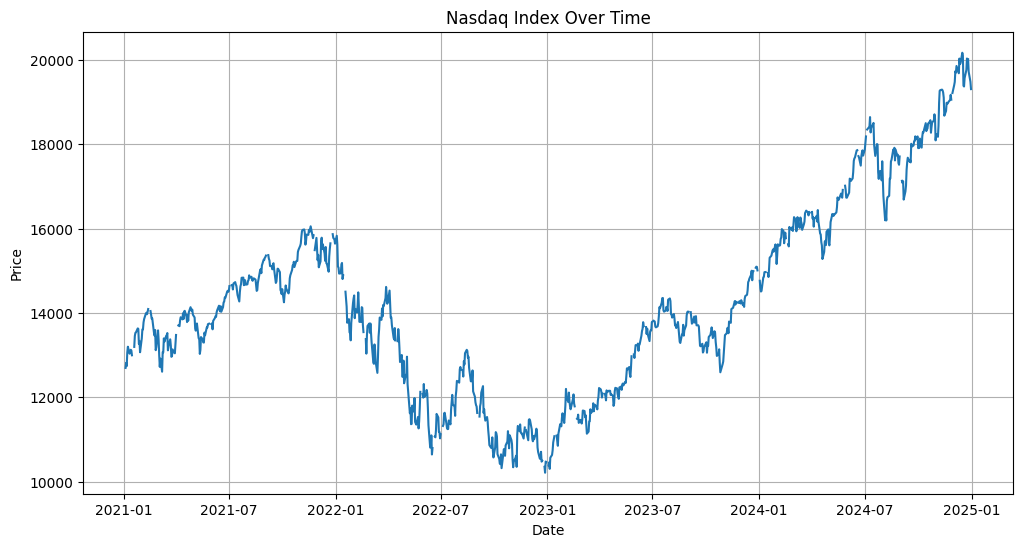

In [131]:
nasdaq_dataset['observation_date'] = pd.to_datetime(nasdaq_dataset['observation_date'])

index_value = nasdaq_dataset.sort_values(by='observation_date')

plt.figure(figsize=(12, 6))
plt.plot(index_value['observation_date'], index_value['NASDAQCOM'])
plt.title('Nasdaq Index Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [132]:
nasdaq_train = index_value.set_index('observation_date')["NASDAQCOM"].loc["2021-01-06":"2024-01-06"].to_numpy()
nasdaq_test = index_value.set_index('observation_date')["NASDAQCOM"].loc["2024-01-06":"2025-01-06"].to_numpy()

In [133]:
def interpolateSignal(signal):
  for i in range(len(signal)):
    if np.isnan(signal[i]):
      signal[i] = 0

  for i in range(len(signal)-1):
    if signal[i] == 0:
      signal[i] = (signal[i-1] + signal[i+1])/2

  signal[0] = signal[1]
  signal[-1] = signal[-2]
  return signal

In [134]:
nasdaq_train = interpolateSignal(nasdaq_train)
nasdaq_test = interpolateSignal(nasdaq_test)

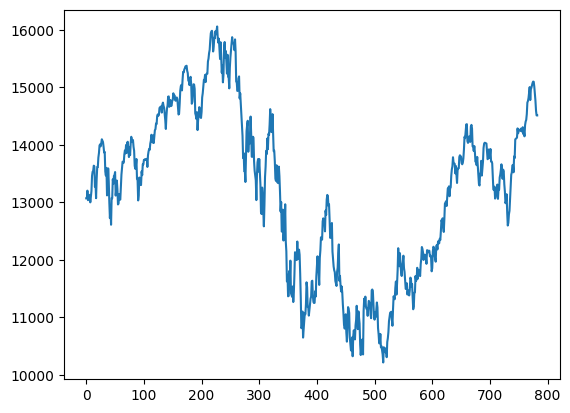

In [135]:
plt.plot(nasdaq_train)

# ***Filter Design***

In [136]:
def find_LMMSE_filter(signal, lengthscale):
  corr_vector = np.correlate(signal, signal, mode="full")[(len(signal) - 1):]
  r = corr_vector[1 : (lengthscale + 1)]
  R = np.zeros((r.size, r.size))
  for i in range(len(r)):
      for j in range(len(r)):
          R[i, j] = corr_vector[abs(i - j)]
  a = np.linalg.solve(R, r)
  return a

In [137]:
def predict(signal, filter_coeff, lengthscale):
  signal_predict = []
  for tao in range(len(signal)-lengthscale):
    signal_predict.append(np.dot(filter_coeff, np.flip(signal[tao:tao+lengthscale])))
  signal_predict = np.array(signal_predict)
  return signal_predict

In [138]:
def evaluate_filter(signal, filter_coeff, lengthscale):
  signal_predict = predict(signal, filter_coeff, lengthscale)
  time_index = np.arange(len(signal))
  plt.plot(time_index[:], signal[:])
  plt.plot(time_index[lengthscale:], signal_predict)
  plt.legend(["Actual", "Predicted"])
  plt.show()
  R2_score = 1 - np.sum((signal_predict - signal[lengthscale:])**2) / np.sum((signal[lengthscale:] - np.mean(signal[lengthscale:]))**2)
  print("R2 Score: " + str(R2_score))

In [139]:
def show_filter_coeff(filter_coeff, lengthscale):
  print("-----For lengthscale of " + str(lengthscale) + "-----" + "\n")
  print(filter_coeff)
  print("\n")
  print("-----For lengthscale of " + str(lengthscale) + "-----" + "\n")

# ***DL Estimator and Helper Functions Design***

In [140]:
def create_windows(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [141]:
def data_pre_processor(train_data, test_data , window_size):

  scaled_train_data = (train_data - np.mean(train_data)) / np.std(train_data)
  scaled_test_data = (test_data - np.mean(test_data)) / np.std(test_data)

  X_train, y_train = create_windows(scaled_train_data, window_size)
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  x_test, y_test = create_windows(scaled_test_data, window_size)
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

  return X_train, y_train, x_test, y_test

In [142]:
class timeSeriesModel(keras.Model):
  def __init__(self):
        super().__init__()

        self.gru_layer = tf.keras.layers.GRU(16, return_sequences=True)
        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.output_layer = tf.keras.layers.Dense(1, activation='linear')

  def call(self, inputs):
    x = self.gru_layer(inputs)
    x = self.dropout_1(x)
    x = self.flatten(x)
    x = self.output_layer(x)
    return x

In [143]:
def initialize_train_model(x_train, y_train):
  input_shape = (x_train.shape[1], x_train.shape[2])
  input_layer = tf.keras.layers.Input(shape=input_shape)
  time_series_model_instance = timeSeriesModel()

  output_tensor = time_series_model_instance(input_layer)

  model = tf.keras.Model(inputs=input_layer, outputs=output_tensor)
  model.summary()
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='mse')
  history = model.fit(x_train, y_train, epochs=25, batch_size=1)

  plt.figure(figsize=(10, 6))
  plt.plot(model.history.history ['loss'], label='Training Loss')
  plt.title('Model Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)
  plt.show()

  return model

In [144]:
def test_deep_learning_model(model, x_test, y_test, x_train, y_train, set_test, window_size):
    predicted_price = model.predict(x_test)
    R2_score_dl = 1 - np.sum((predicted_price - y_test.reshape(-1, 1))**2) / np.sum((y_test.reshape(-1, 1) - np.mean(y_test.reshape(-1, 1)))**2)
    print(f"R2 Score for Deep Learning Model: {R2_score_dl}")
    train_mse = model.evaluate(x_train, y_train, verbose=0)
    test_mse = model.evaluate(x_test, y_test, verbose=0)

    print(f"Deep Learning Model Training MSE: {train_mse:.4f}")
    print(f"Deep Learning Model Test MSE: {test_mse:.4f}")
    descaled_prediction = (predicted_price * np.std(set_test)) + np.mean(set_test)
    plt.plot(set_test[window_size:], label='Actual')
    plt.plot(descaled_prediction, label='Predicted')
    plt.legend()
    plt.show()

# ***DL Estimator Training***

**Gold Model**

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_series_model_4             │ (None, 1)              │         1,073 │
│ (timeSeriesModel)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073 (4.19 KB)

 Trainable params: 1,073 (4.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1670
Epoch 2/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0724
Epoch 3/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0641
Epoch 4/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0524
Epoch 5/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0461
Epoch 6/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0468
Epoch 7/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0375
Epoch 8/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0424
Epoch 9/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0386
Epoch 10/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0356
Epoch 11/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0376
Epoch 12/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0415
Epoch 13/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0336
Epoch 14/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0343
Epoch 15/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lo

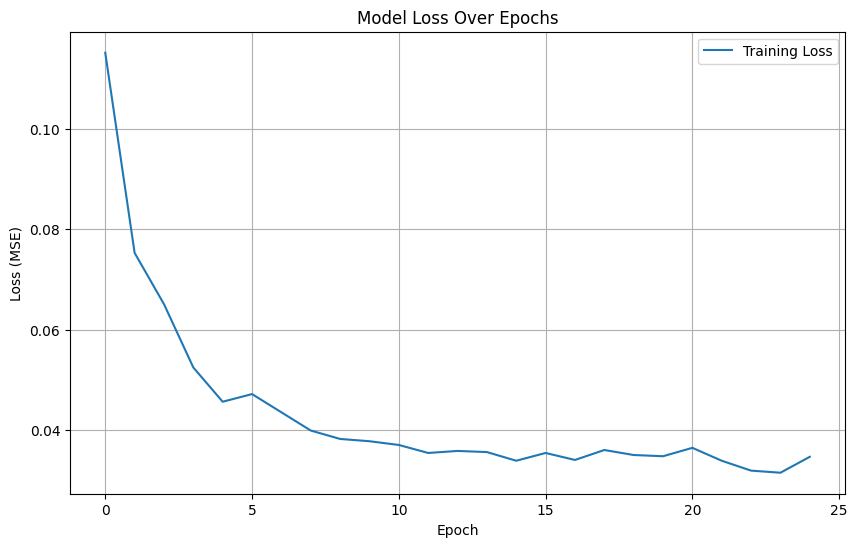

In [145]:
gold_x_train, gold_y_train, gold_x_test, gold_y_test = data_pre_processor(gold_price_array_train, gold_price_array_test, 10)
gold_model = initialize_train_model(gold_x_train, gold_y_train)

**Nasdaq Model**

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_series_model_5             │ (None, 1)              │         1,073 │
│ (timeSeriesModel)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073 (4.19 KB)

 Trainable params: 1,073 (4.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1800
Epoch 2/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0631
Epoch 3/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0557
Epoch 4/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0499
Epoch 5/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0398
Epoch 6/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0374
Epoch 7/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0325
Epoch 8/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0330
Epoch 9/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0298
Epoch 10/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0280
Epoch 11/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0318
Epoch 12/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0253
Epoch 13/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0281
Epoch 14/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0249
Epoch 15/25
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - lo

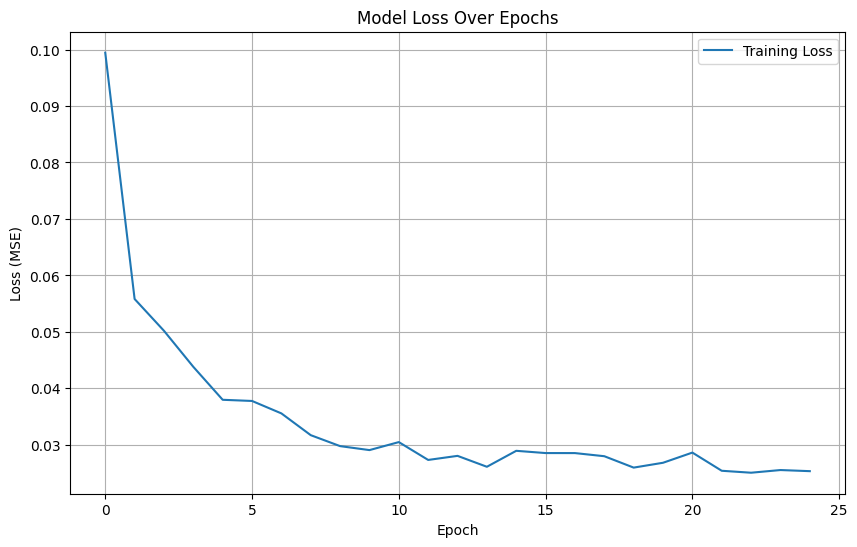

In [146]:
nasdaq_x_train, nasdaq_y_train, nasdaq_x_test, nasdaq_y_test = data_pre_processor(nasdaq_train, nasdaq_test, 10)
nasdaq_model = initialize_train_model(nasdaq_x_train, nasdaq_y_train)

# ***Prediction Using LMMSE***

**Gold Predictions**

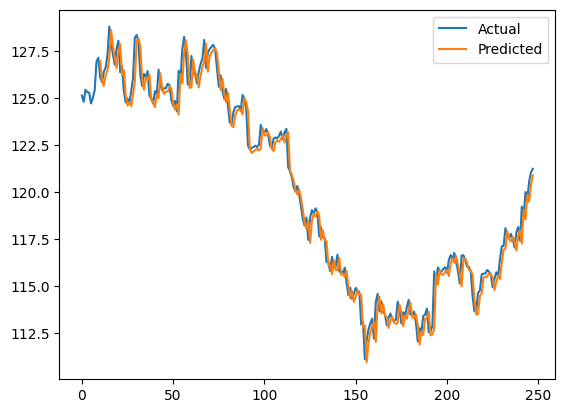

R2 Score: 0.9788657318391716
-----For lengthscale of 10-----

[ 9.97692784e-01  4.89447281e-03  2.08831155e-03 -9.15571800e-03
 -2.01195840e-03  1.06317525e-02 -2.25951725e-04 -6.39695180e-03
 -2.66044581e-03  3.71595176e-03]


-----For lengthscale of 10-----



In [147]:
lengthscale = 10
filter_coeff = find_LMMSE_filter(gold_price_array_train, lengthscale)
evaluate_filter(gold_price_array_test, filter_coeff, lengthscale)
show_filter_coeff(filter_coeff, lengthscale)

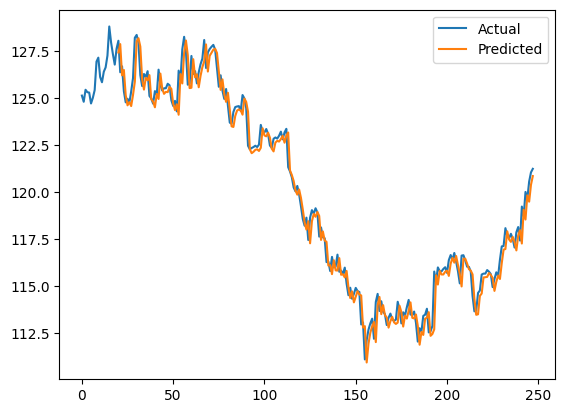

R2 Score: 0.9781384730110343
-----For lengthscale of 20-----

[ 9.97719587e-01  4.88915751e-03  1.91078193e-03 -9.12093524e-03
 -2.00526594e-03  1.07821352e-02 -2.54095351e-04 -6.57461447e-03
 -2.71043981e-03  1.40099522e-02 -1.45573832e-03 -4.64153178e-03
 -4.81722044e-03  6.25591520e-03 -6.93769818e-03  8.97778670e-03
 -1.04502829e-02 -2.68624668e-03  1.94535254e-02 -1.38285239e-02]


-----For lengthscale of 20-----



In [148]:
lengthscale = 20
filter_coeff = find_LMMSE_filter(gold_price_array_train, lengthscale)
evaluate_filter(gold_price_array_test, filter_coeff, lengthscale)
show_filter_coeff(filter_coeff, lengthscale)

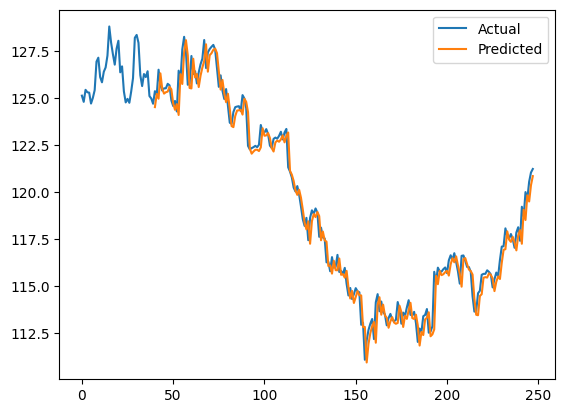

R2 Score: 0.977256690987826
-----For lengthscale of 40-----

[ 9.98039980e-01  4.72698989e-03  1.30188962e-03 -8.48797389e-03
 -1.90494544e-03  1.00581750e-02  3.92787776e-04 -6.53598813e-03
 -3.30929837e-03  1.48031915e-02 -1.88929285e-03 -4.89342847e-03
 -4.25359462e-03  6.18585178e-03 -7.37064175e-03  9.27629193e-03
 -1.04274574e-02 -2.84193422e-03  1.96436121e-02 -2.16778230e-02
  4.52472903e-03  9.40658968e-03 -2.70083454e-03 -1.84206887e-02
  1.91939856e-02 -1.04269649e-02  5.22264214e-04  1.31908214e-02
 -1.15002125e-02 -2.50588557e-03  9.90939876e-03 -4.88646468e-03
 -4.04385773e-03  1.05976986e-02 -7.75891274e-03  3.07030635e-03
  4.20522423e-03 -7.70520584e-03  5.93764411e-03 -2.89693279e-03]


-----For lengthscale of 40-----



In [149]:
lengthscale = 40
filter_coeff = find_LMMSE_filter(gold_price_array_train, lengthscale)
evaluate_filter(gold_price_array_test, filter_coeff, lengthscale)
show_filter_coeff(filter_coeff, lengthscale)

**Nasdaq Predictions**

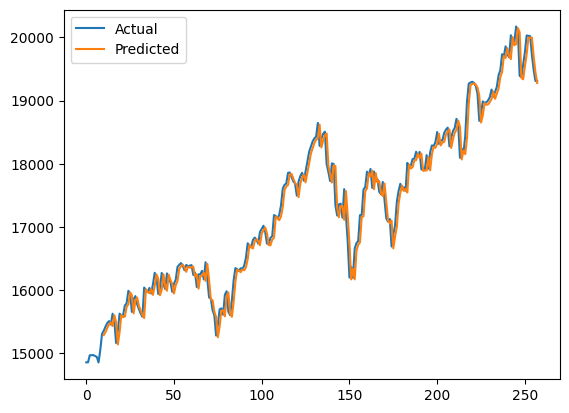

R2 Score: 0.9765185405939539
-----For lengthscale of 10-----

[ 0.99864882  0.00694757 -0.00937409  0.01111851 -0.00289932 -0.00305686
 -0.00645185  0.00579254  0.00555069 -0.00779494]


-----For lengthscale of 10-----



In [150]:
lengthscale = 10
filter_coeff = find_LMMSE_filter(nasdaq_train, lengthscale)
evaluate_filter(nasdaq_test, filter_coeff, lengthscale)
show_filter_coeff(filter_coeff, lengthscale)

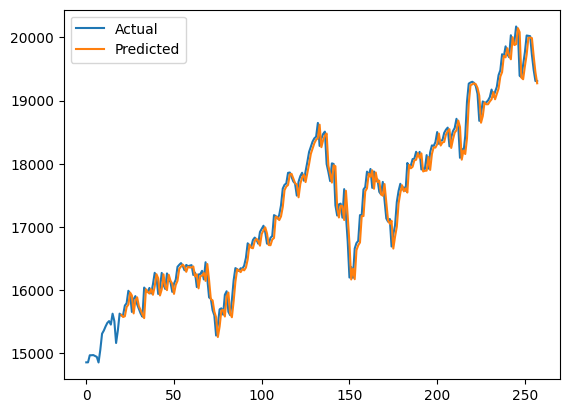

R2 Score: 0.97478933944287
-----For lengthscale of 20-----

[ 0.9987234   0.00680601 -0.00930409  0.01132566 -0.00321931 -0.00277261
 -0.00661621  0.00576095  0.00547286 -0.00501123  0.00203411 -0.00962146
  0.01514176 -0.0131643  -0.01326605  0.01645155 -0.01129338  0.01686733
 -0.0023194  -0.00350173]


-----For lengthscale of 20-----



In [151]:
lengthscale = 20
filter_coeff = find_LMMSE_filter(nasdaq_train, lengthscale)
evaluate_filter(nasdaq_test, filter_coeff, lengthscale)
show_filter_coeff(filter_coeff, lengthscale)

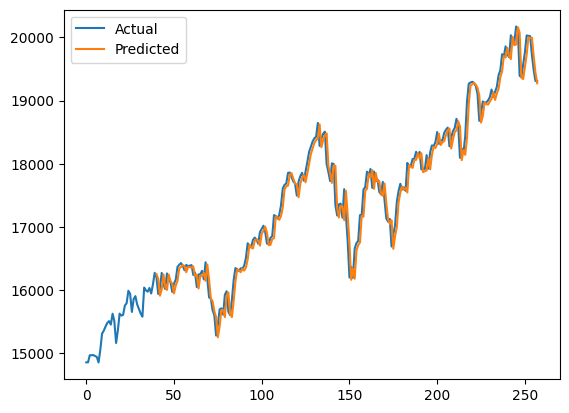

R2 Score: 0.9717360382723484
-----For lengthscale of 40-----

[ 0.99915759  0.00649444 -0.0099222   0.01185646 -0.00311033 -0.00300167
 -0.00670824  0.00622604  0.0050813  -0.00489658  0.00224126 -0.0099281
  0.01536586 -0.01327582 -0.01342311  0.01659539 -0.0114522   0.01703234
 -0.00269415 -0.00268013  0.00481349 -0.01092169  0.01379427 -0.01325464
  0.01192414 -0.00717382  0.00210721  0.00167184 -0.00465031 -0.00157351
  0.00112064  0.00205675 -0.01331724  0.01601005 -0.00255022 -0.01638213
  0.01836136  0.01012869 -0.03176844  0.01917095]


-----For lengthscale of 40-----



In [152]:
lengthscale = 40
filter_coeff = find_LMMSE_filter(nasdaq_train, lengthscale)
evaluate_filter(nasdaq_test, filter_coeff, lengthscale)
show_filter_coeff(filter_coeff, lengthscale)

# ***Prediction Using DL***

**Gold Predictions**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
R2 Score for Deep Learning Model: 0.978678522946904
Deep Learning Model Training MSE: 0.0229
Deep Learning Model Test MSE: 0.0212


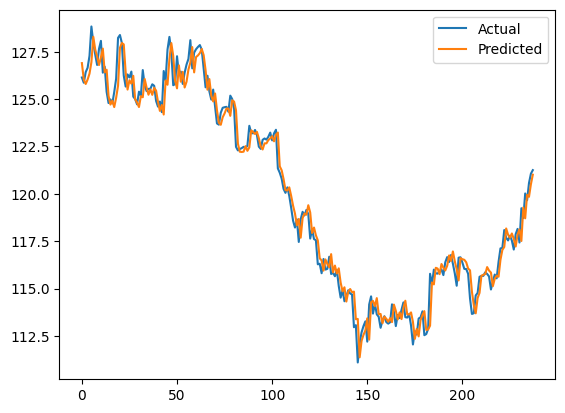

In [153]:
test_deep_learning_model(gold_model, gold_x_test, gold_y_test, gold_x_train, gold_y_train, gold_price_array_test, 10)

Nasdaq Predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
R2 Score for Deep Learning Model: 0.9728720555445527
Deep Learning Model Training MSE: 0.0206
Deep Learning Model Test MSE: 0.0248


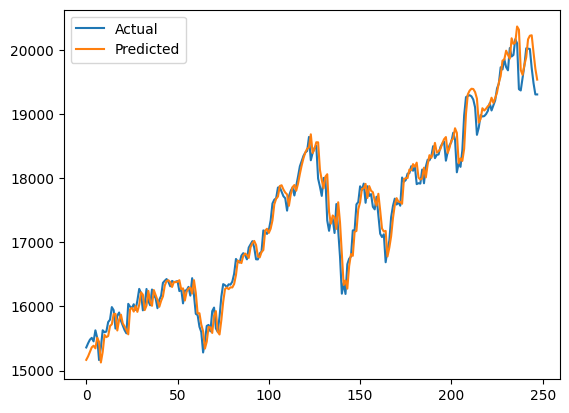

In [154]:
test_deep_learning_model(nasdaq_model, nasdaq_x_test, nasdaq_y_test, nasdaq_x_train, nasdaq_y_train, nasdaq_test, 10)

# ***Trade Policy Design***

In [155]:
def sell_asset(amount, price, asset_holdings, bank_account):
    if amount <= asset_holdings:
        asset_holdings -= amount
        earnings = amount * price
        bank_account += earnings
        print(f"You sold {amount} asset for ${earnings:.2f}.")
    else:
        print("Not enough asset to sell!")
    return asset_holdings, bank_account

def buy_asset(amount, price, asset_holdings, bank_account):
    cost = amount * price
    if cost <= bank_account:
        bank_account -= cost
        asset_holdings += amount
        print(f"You bought {amount} asset for ${cost:.2f}.")
    else:
        print("Not enough money to buy asset!")
    return asset_holdings, bank_account

In [156]:
def threshold_controller(real_signal, predict_signal, lengthscale, threshold):
  if(predict_signal[-1] > real_signal[lengthscale + len(predict_signal) - 1] +  real_signal[lengthscale + len(predict_signal) - 1] * threshold):
    return "buy"
  elif(predict_signal[-1] < real_signal[lengthscale + len(predict_signal) - 1] - real_signal[lengthscale + len(predict_signal) - 1] * threshold):
    return "sell"
  else:
    return False #Noise situation

In [157]:
def control_stop_loss(predicted_signal, stop_threshold):
  if(predicted_signal[-1] < predicted_signal[-2] * stop_threshold):
    return True
  else:
    return False

# **Simulation Loop**

In [158]:
def run_simulation(train_values, test_values, estimator_type='lmmse', model=None, lengthscale=20, window_size=10, initial_money=5000, initial_asset=50, threshold=0.01, stop_threshold=0.95, period=5, trade_ratio=0.001):

    if estimator_type == 'lmmse':
        filter_coeff = find_LMMSE_filter(train_values, lengthscale)
        predicted_price = predict(test_values, filter_coeff, lengthscale)
        offset = lengthscale
    elif estimator_type == 'deep_learning':
        if model is None:
            raise ValueError("Model must be provided for deep_learning estimator.")

        _, _, x_test_dl, _ = data_pre_processor(train_values, test_values, window_size)
        predicted_price = ((model.predict(x_test_dl).flatten()) * np.std(test_values)) + np.mean(test_values)
        offset = window_size
    else:
        raise ValueError("Invalid estimator_type. Use 'lmmse' or 'deep_learning'.")


    bank_account = initial_money
    asset_holdings = initial_asset
    start_price = test_values[offset]
    initial_total_value = initial_money + (initial_asset * start_price)
    money_history = [bank_account]
    asset_history = [asset_holdings]
    portfolio_history = [initial_total_value]
    buy_and_hold_history = [initial_total_value]
    current_predictions = []

    print(f"--- Starting Simulation ({estimator_type}) ---")
    print(f"Initial Bank: ${bank_account:.2f}, Asset: {asset_holdings}")

    for i in range(len(predicted_price)):
        current_predictions.append(predicted_price[i])

        current_index = offset + i
        current_price = test_values[current_index]
        current_real_history = test_values[:current_index + 1]

        if control_stop_loss(current_real_history, stop_threshold):
            trade_amount = asset_holdings * trade_ratio * (asset_holdings / initial_asset)
            asset_holdings, bank_account = sell_asset(trade_amount, current_price, asset_holdings, bank_account)
        else:
            action = threshold_controller(test_values, current_predictions, offset, threshold)

            if action == "buy":
                trade_amount = bank_account * trade_ratio * (bank_account / initial_money)
                asset_holdings, bank_account = buy_asset(trade_amount, current_price, asset_holdings, bank_account)
            elif action == "sell":
                trade_amount = asset_holdings * trade_ratio * (asset_holdings / initial_asset)
                asset_holdings, bank_account = sell_asset(trade_amount, current_price, asset_holdings, bank_account)

        money_history.append(bank_account)
        asset_history.append(asset_holdings)

        current_portfolio_val = bank_account + (asset_holdings * current_price)
        current_bh_val = initial_money + (initial_asset * current_price)

        portfolio_history.append(current_portfolio_val)
        buy_and_hold_history.append(current_bh_val)

    final_portfolio = portfolio_history[-1]
    initial_portfolio = portfolio_history[0]
    revenue_pct = ((final_portfolio - initial_portfolio) / initial_portfolio) * 100

    print(f"Ending Bank: ${bank_account:.2f}, Asset: {asset_holdings}")
    print(f"Final Portfolio Value: ${final_portfolio:.2f}")
    print(f"Revenue Percentage: {revenue_pct:.2f}%")

    fig, (ax_val, ax_bal) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    ax_val.plot(portfolio_history, label='Strategy Portfolio Value', color='blue')
    ax_val.plot(buy_and_hold_history, label='Buy & Hold Value', color='gray', linestyle='--')
    ax_val.set_ylabel('Total Value ($)')
    ax_val.set_title(f'Performance Comparison - {estimator_type.upper()}')
    ax_val.legend()
    ax_val.grid(True)

    color = 'tab:green'
    ax_bal.set_xlabel('Time Steps')
    ax_bal.set_ylabel('Bank Account ($)', color=color)
    ax_bal.plot(money_history, color=color, label='Bank Account')
    ax_bal.tick_params(axis='y', labelcolor=color)
    ax_bal.grid(True, linestyle='--', alpha=0.5)

    ax2 = ax_bal.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Asset Holdings', color=color)
    ax2.plot(asset_history, color=color, label='Asset Holdings')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()



**Gold Simulation with LMMSE**

--- Starting Simulation (lmmse) ---
Initial Bank: $10000.00, Asset: 100
Not enough money to buy asset!
You sold 10.0 asset for $1282.30.
Not enough money to buy asset!
You sold 8.1 asset for $1024.89.
You sold 6.707610000000002 asset for $848.38.
You sold 5.653895513912101 asset for $721.49.
Not enough money to buy asset!
You sold 4.835602215391678 asset for $615.38.
Not enough money to buy asset!
Not enough money to buy asset!
You sold 4.186464268193322 asset for $496.72.
Not enough money to buy asset!
Not enough money to buy asset!
You sold 3.6622380581821186 asset for $410.65.
You sold 3.232398914224907 asset for $369.01.
You sold 2.8752964732752706 asset for $332.90.
You sold 2.575206709805424 asset for $300.35.
Not enough money to buy asset!
You sold 2.320472972839993 asset for $276.69.
You sold 2.102297224625885 asset for $252.32.
Ending Bank: $16931.08, Asset: 43.748517649549306
Final Portfolio Value: $22235.59
Revenue Percentage: -2.51%


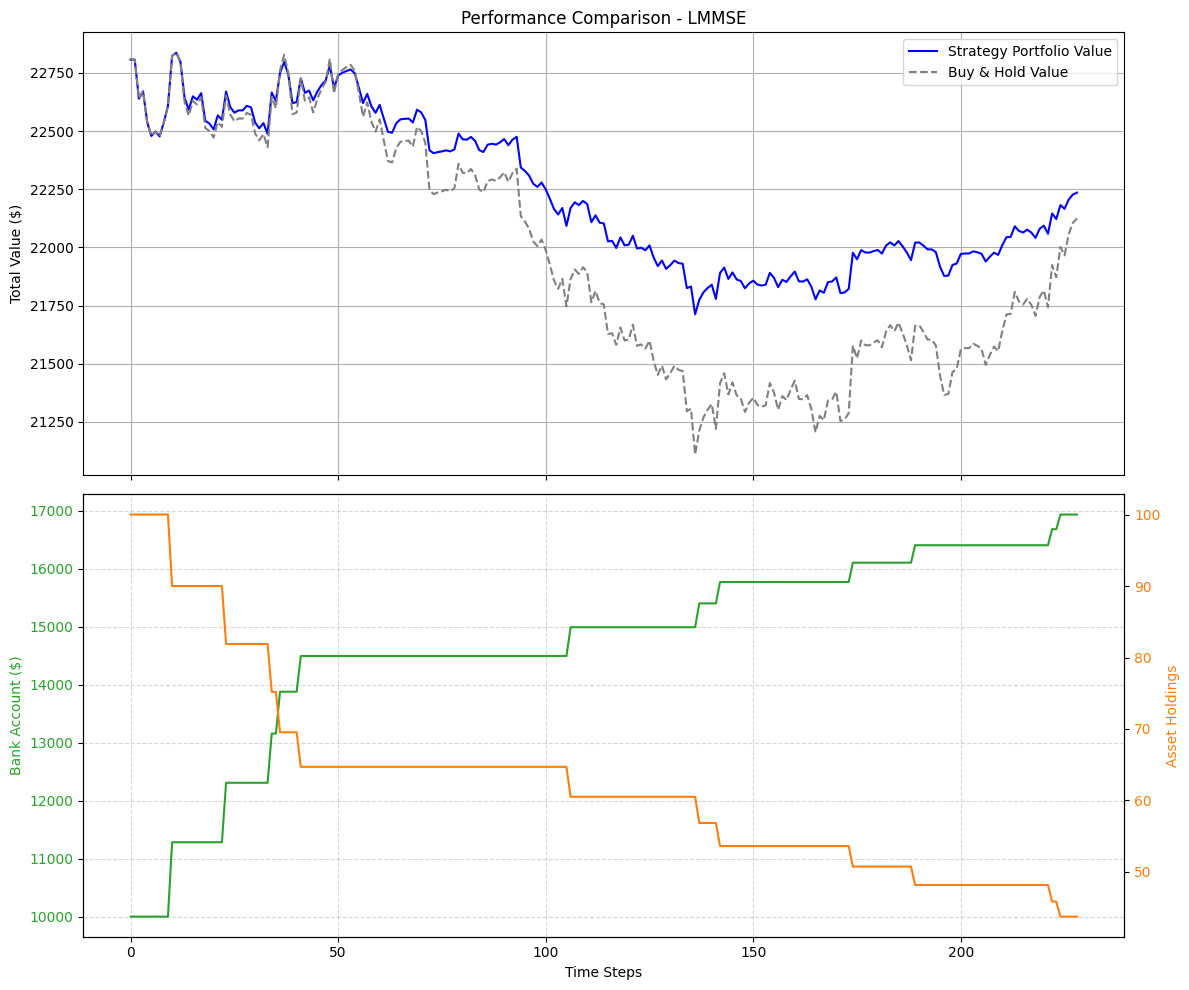

In [159]:
run_simulation(gold_price_array_train, gold_price_array_test, estimator_type='lmmse', threshold=0.01, stop_threshold=0.95, trade_ratio=0.1, initial_money = 10000, initial_asset = 100)

**Nasdaq Simulation with LMMSE**

--- Starting Simulation (lmmse) ---
Initial Bank: $10000.00, Asset: 100
You sold 0.1 asset for $1575.66.
You sold 0.09980010000000002 asset for $1595.87.
Not enough money to buy asset!
You sold 0.09960079900079961 asset for $1579.58.
You sold 0.09940209461098165 asset for $1594.57.
You sold 0.0992039844510536 asset for $1596.38.
You sold 0.09900646615337637 asset for $1611.32.
Not enough money to buy asset!
You sold 0.09880953736209339 asset for $1607.97.
Not enough money to buy asset!
You sold 0.09861319573306038 asset for $1604.01.
You sold 0.09841743893377554 asset for $1584.86.
You sold 0.09822226464331019 asset for $1607.84.
Not enough money to buy asset!
You sold 0.09802767055223993 asset for $1592.80.
You sold 0.09783365436257627 asset for $1608.60.
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
You sold 0.0976402137876987 asset for $1508.67.
You sold 0.09744734655228733 asset for $1529.60.
You sold 0.09725505039225586 asset for $154

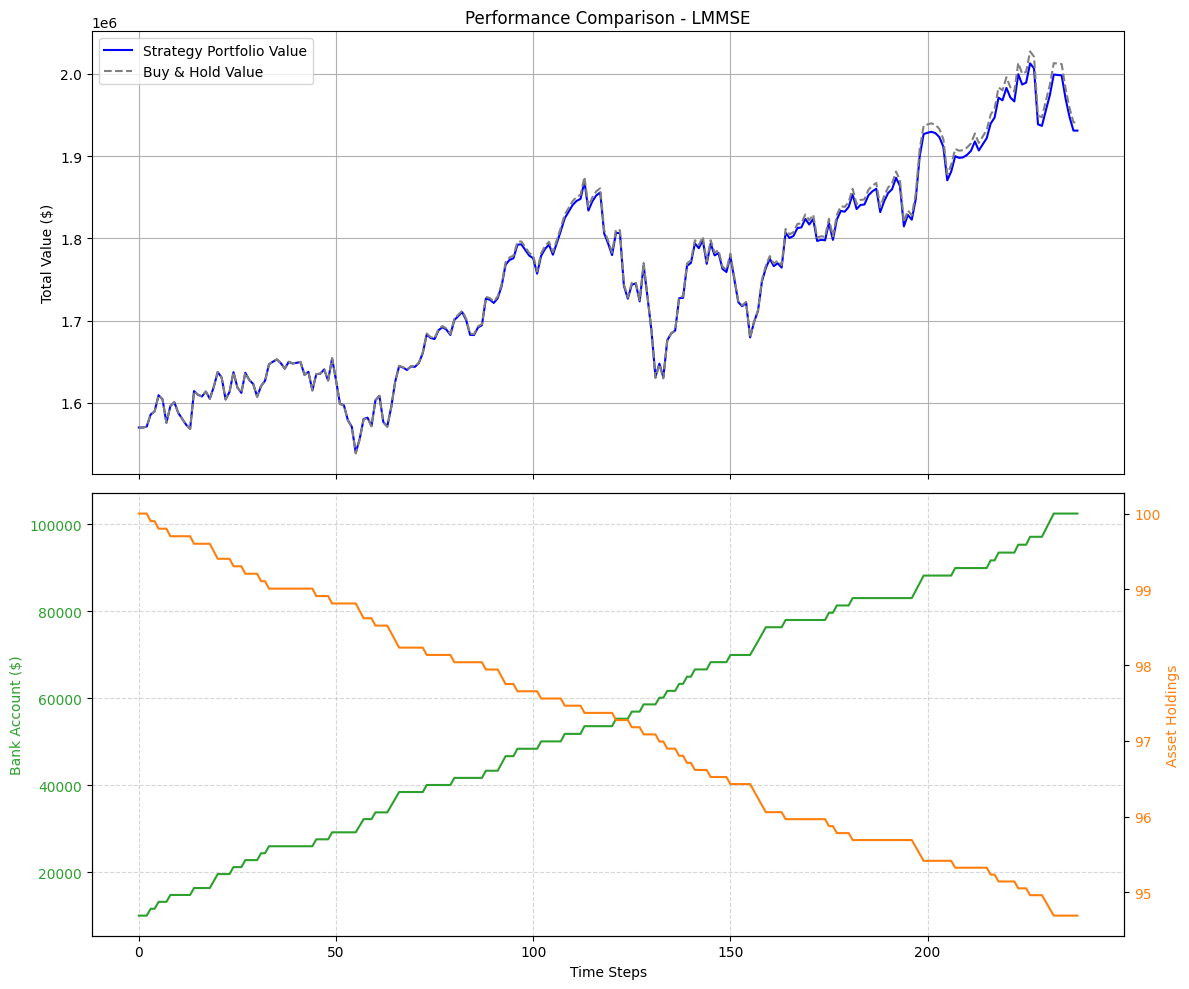

In [160]:
run_simulation(nasdaq_train, nasdaq_test, estimator_type='lmmse', threshold=0.01, stop_threshold=0.95, trade_ratio=0.001, initial_money = 10000, initial_asset = 100)

**Gold Simulation with DL**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--- Starting Simulation (deep_learning) ---
Initial Bank: $10000.00, Asset: 100
You sold 10.0 asset for $1288.30.
Not enough money to buy asset!
You sold 8.1 asset for $1038.66.
Not enough money to buy asset!
You sold 6.707610000000002 asset for $848.71.
You sold 5.653895513912101 asset for $715.10.
You sold 4.835602215391678 asset for $617.07.
Not enough money to buy asset!
You sold 4.186464268193322 asset for $532.77.
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
Not enough money to buy asset!
You sold 3.6622380581821186 asset for $418.08.
Not enough money to buy asset!
Not enough money to buy asset!
You sold 3.232398914224907 asset for $374.25.
You sold 2.8752964732752706 asset for $335.35.
Not enough money to buy asset!
Not enough money to buy asset!
You sold 2.575206709805424

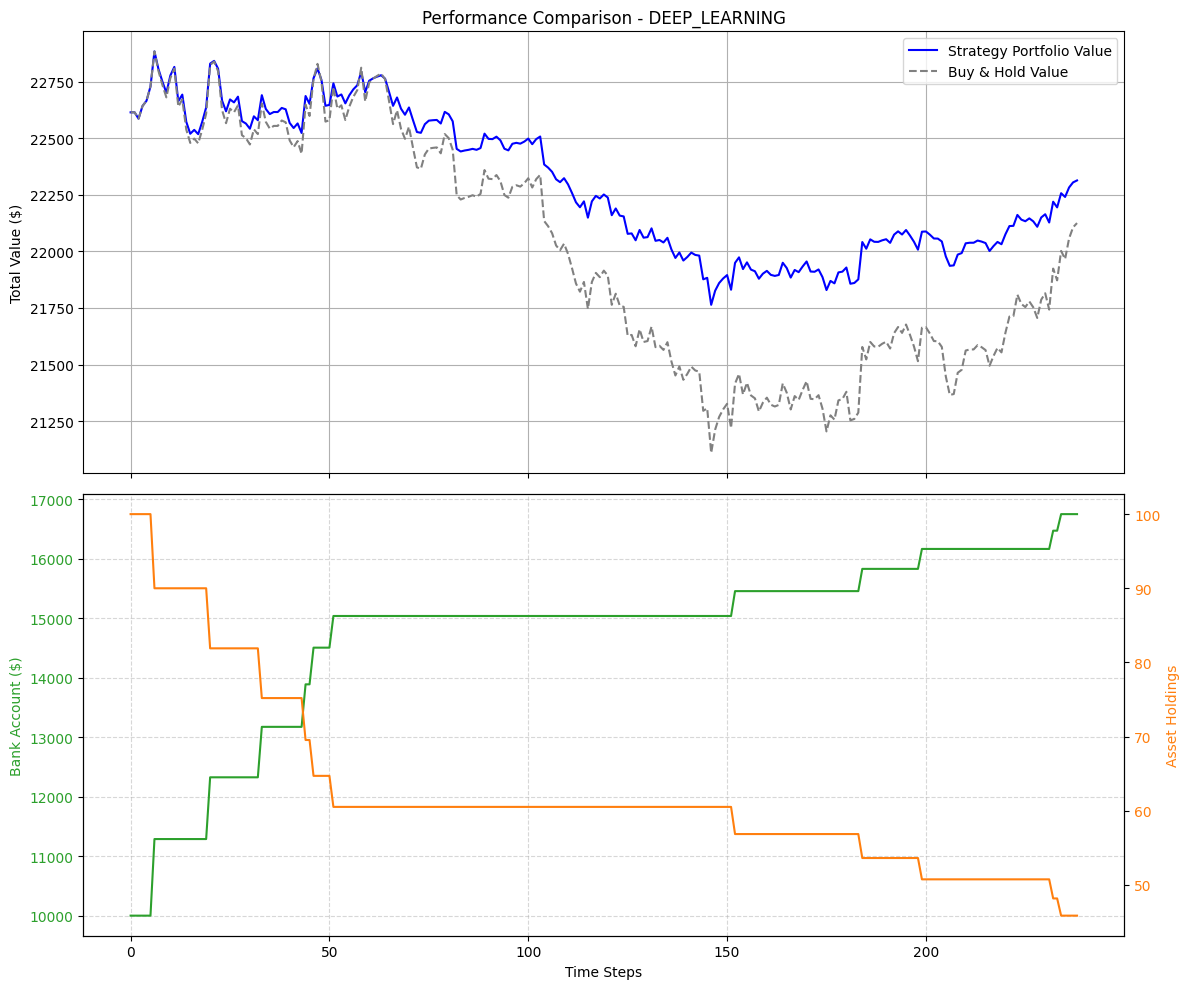

In [161]:
run_simulation(gold_price_array_train, gold_price_array_test, estimator_type='deep_learning', model=gold_model, threshold=0.01, stop_threshold=0.95, trade_ratio=0.1, initial_money = 10000, initial_asset = 100)

**Nasdaq Simulation with DL**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--- Starting Simulation (deep_learning) ---
Initial Bank: $10000.00, Asset: 100
You sold 0.1 asset for $1536.03.
You sold 0.09980010000000002 asset for $1539.51.
You sold 0.09960079900079961 asset for $1542.01.
You sold 0.09940209461098165 asset for $1553.46.
Not enough money to buy asset!
You sold 0.0992039844510536 asset for $1523.94.
You sold 0.09900646615337637 asset for $1547.37.
You sold 0.09880953736209339 asset for $1556.91.
You sold 0.09861319573306038 asset for $1576.89.
Not enough money to buy asset!
You sold 0.09841743893377554 asset for $1560.82.
You sold 0.09822226464331019 asset for $1575.64.
You sold 0.09802767055223993 asset for $1577.45.
You sold 0.09783365436257627 asset for $1592.24.
Not enough money to buy asset!
You sold 0.0976402137876987 asset for $1588.94.
You sold 0.09744734655228733 asset for $1585.04.
You sold 0.09725505039225586 asset for $1592.01.
Not enough money to buy asset!
Not enough money to buy asset!
You sold 0

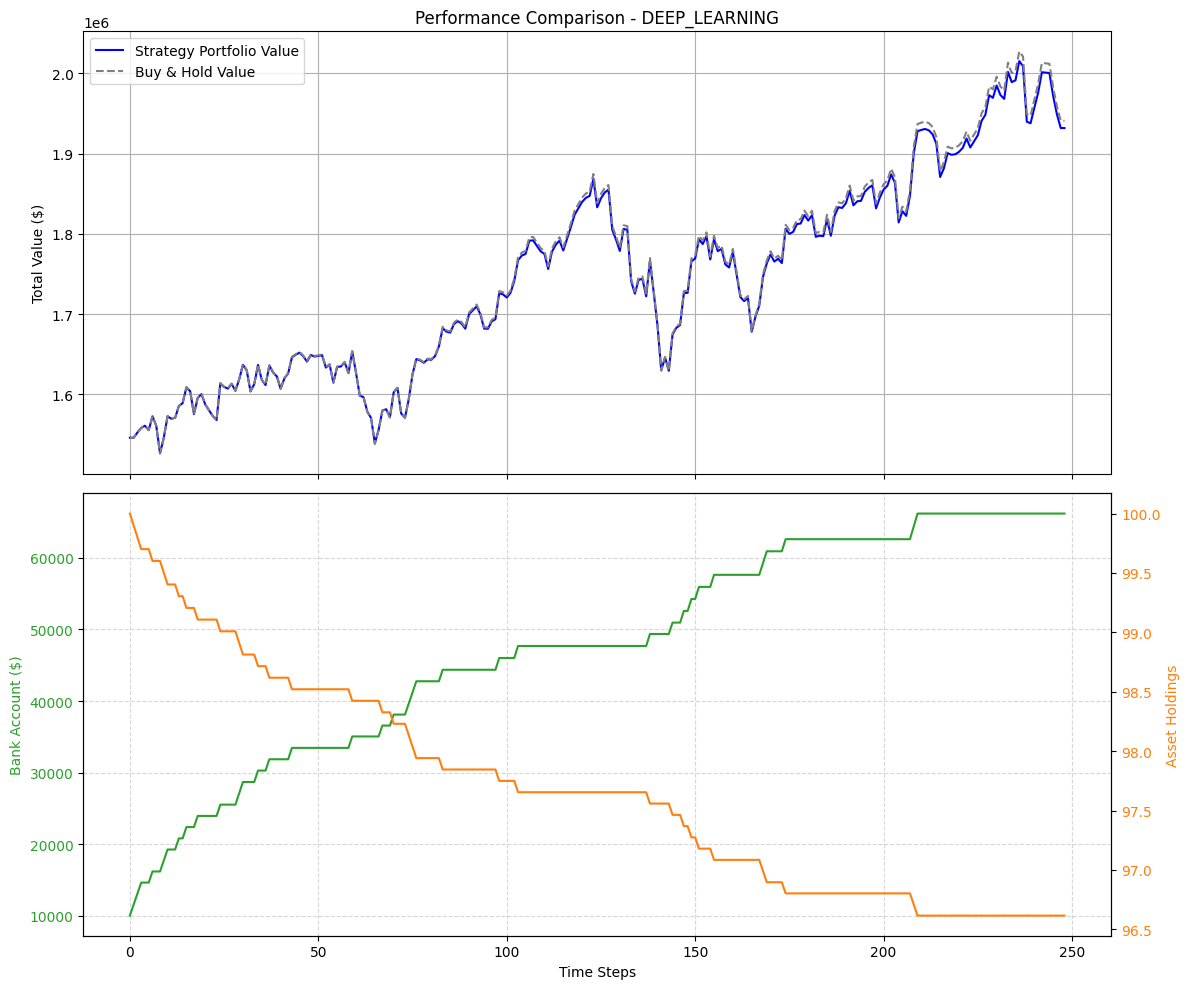

In [162]:
run_simulation(nasdaq_train, nasdaq_test, estimator_type='deep_learning', model=nasdaq_model, threshold=0.01, stop_threshold=0.95, trade_ratio=0.001, initial_money = 10000, initial_asset = 100)